In [1]:
from statsforecast.utils import AirPassengersDF
df = AirPassengersDF

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import TimeSeriesSplit

In [3]:
# Load the data

df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)
ts = df['y']

In [4]:
df

,unique_id,y
ds,,
1949-01-31,1.0,112.0
1949-02-28,1.0,118.0
1949-03-31,1.0,132.0
1949-04-30,1.0,129.0
1949-05-31,1.0,121.0
...,...,...
1960-08-31,1.0,606.0
1960-09-30,1.0,508.0
1960-10-31,1.0,461.0


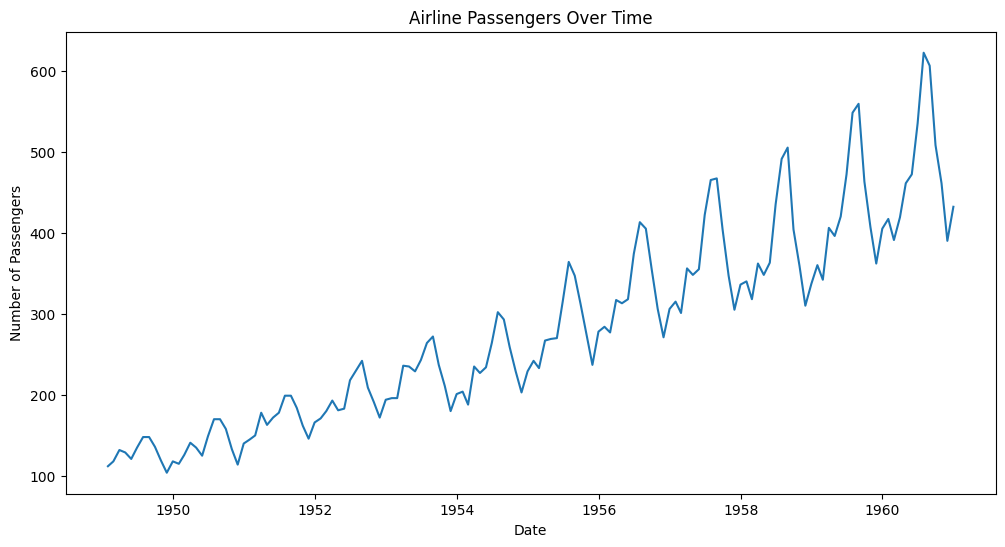

Checking for stationarity in the original time series:
ADF Statistic: 0.8153688792060463
p-value: 0.991880243437641
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}


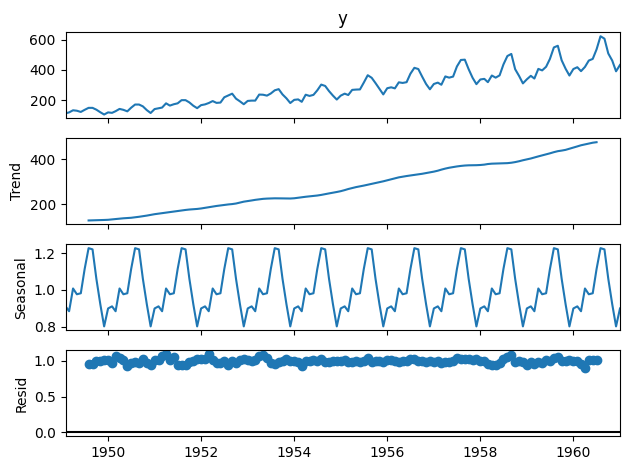

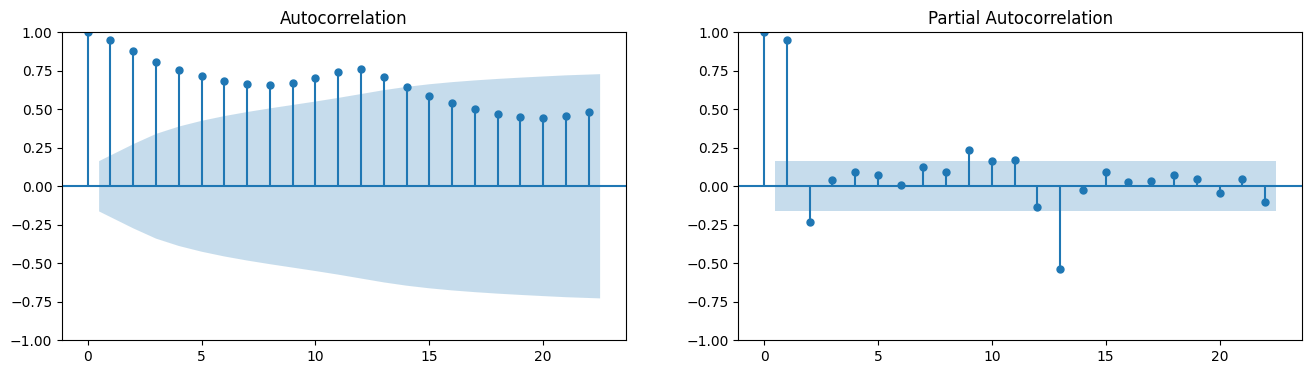

Testing for stationarity in the differenced time series:
ADF Statistic: -2.8292668241699923
p-value: 0.054213290283826474
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}

Testing for stationarity in the second-order differenced time series:
ADF Statistic: -16.384231542468516
p-value: 2.7328918500141235e-29
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}


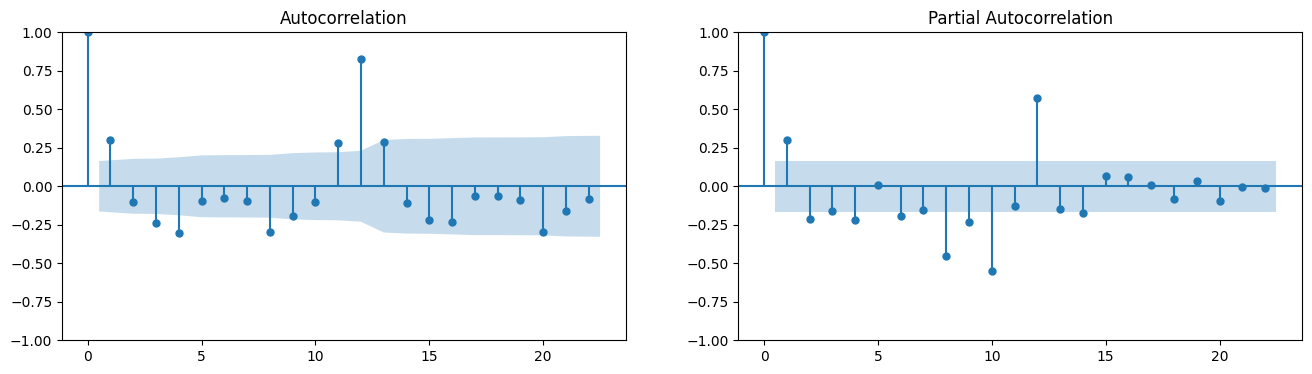

In [6]:
# ... (previous code remains the same)

# After running the code up to step 4, let's interpret the results:

# 1. Exploratory Data Analysis (EDA)
plt.figure(figsize=(12,6))
plt.plot(ts)
plt.title('Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

# 2. Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

print("Checking for stationarity in the original time series:")
test_stationarity(ts)

# 3. Decompose the time series
decomposition = seasonal_decompose(ts, model='multiplicative', period=12)
decomposition.plot()
plt.tight_layout()
plt.show()

# 4. ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
plot_acf(ts, ax=ax1)
plot_pacf(ts, ax=ax2)
plt.show()

print("Testing for stationarity in the differenced time series:")
# 5. Determine the order of differencing (d)
ts_diff = ts.diff().dropna()
test_stationarity(ts_diff)

print("\nTesting for stationarity in the second-order differenced time series:")
# If still not stationary, try second-order differencing
ts_diff2 = ts_diff.diff().dropna()
test_stationarity(ts_diff2)

# Plot ACF and PACF of differenced series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
plot_acf(ts_diff, ax=ax1)
plot_pacf(ts_diff, ax=ax2)
plt.show()

c:\Users\wesst\yayyy\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -508.197
Date:                            Sun, 22 Sep 2024   AIC                           1020.393
Time:                                    22:20:40   BIC                           1026.144
Sample:                                01-31-1949   HQIC                          1022.730
                                     - 12-31-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3076      0.073     -4.186      0.000      -0.452      -0.164
sigma2       137.0108     14.623   

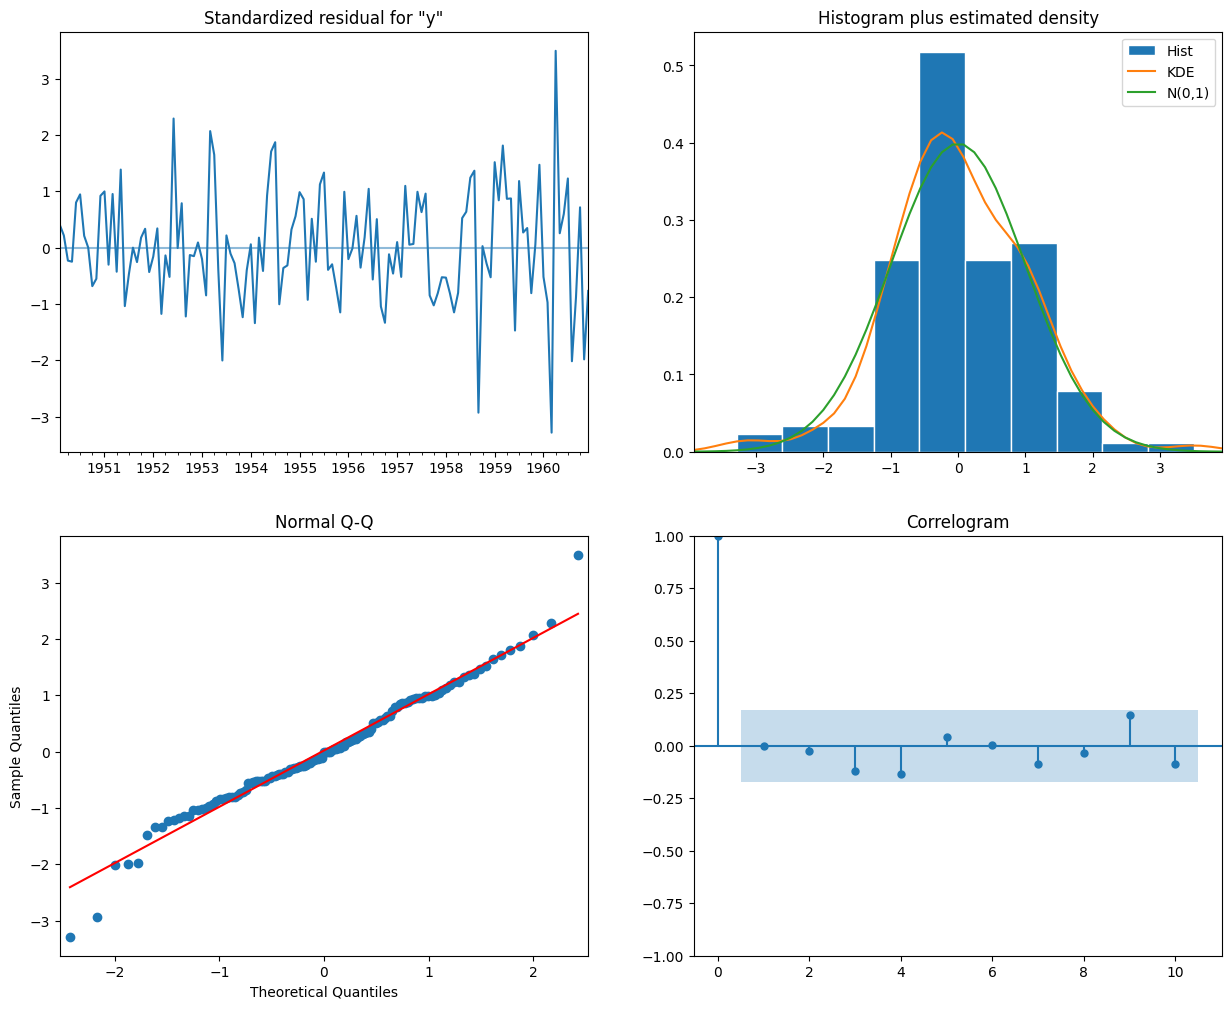

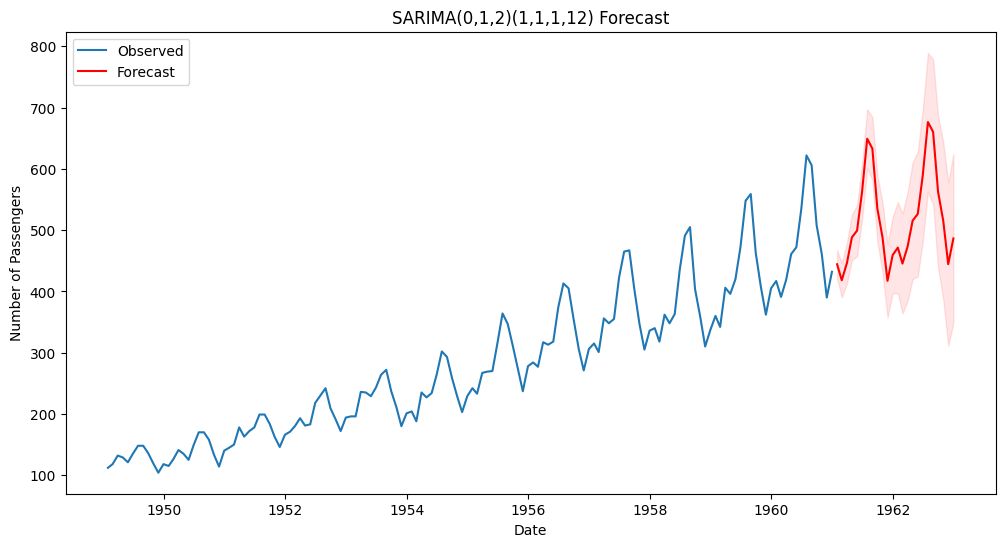

1961-01-31    444.307609
1961-02-28    418.212986
1961-03-31    446.242093
1961-04-30    488.233139
1961-05-31    499.235893
1961-06-30    562.235046
1961-07-31    649.235307
1961-08-31    633.235226
1961-09-30    535.235251
1961-10-31    488.235244
1961-11-30    417.235246
1961-12-31    459.235245
1962-01-31    471.542854
1962-02-28    445.448231
1962-03-31    473.477338
1962-04-30    515.468384
1962-05-31    526.471139
1962-06-30    589.470291
1962-07-31    676.470552
1962-08-31    660.470472
1962-09-30    562.470496
1962-10-31    515.470489
1962-11-30    444.470491
1962-12-31    486.470490
Freq: ME, Name: predicted_mean, dtype: float64


In [7]:
# ... (previous code remains the same)

# Fit the SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the model
model = SARIMAX(ts, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), freq='ME')
results = model.fit()

# Print the model summary
print(results.summary())

# Plot diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast
forecast_steps = 24  # Forecasting 2 years ahead
forecast = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts, label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='r', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='r', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('SARIMA(0,1,2)(1,1,1,12) Forecast')
plt.legend()
plt.show()

# Calculate and print forecast values
print(forecast.predicted_mean)

Cross-validation RMSE scores: [10.39442876300241, 14.989545635078148, 20.604547300406036, 45.27909858680512, 20.58155346475602]
Mean RMSE: 22.369834750009545
Standard deviation of RMSE: 12.074995447224373


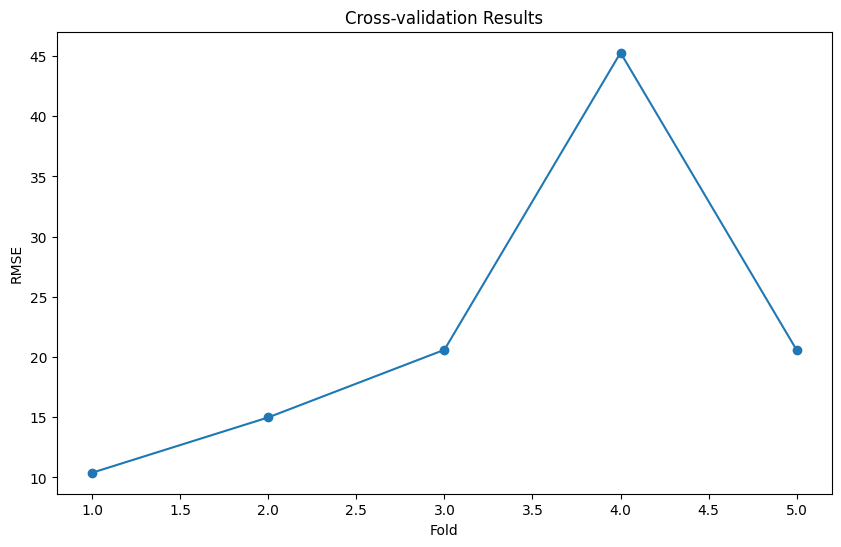

Cross-validation MAPE scores: [np.float64(2.5039097222716022), np.float64(2.80711821953974), np.float64(5.158282236345186), np.float64(10.058234738624563), np.float64(3.5534498642019274)]
Mean MAPE: 4.816198956196604
Standard deviation of MAPE: 2.7775378410339204


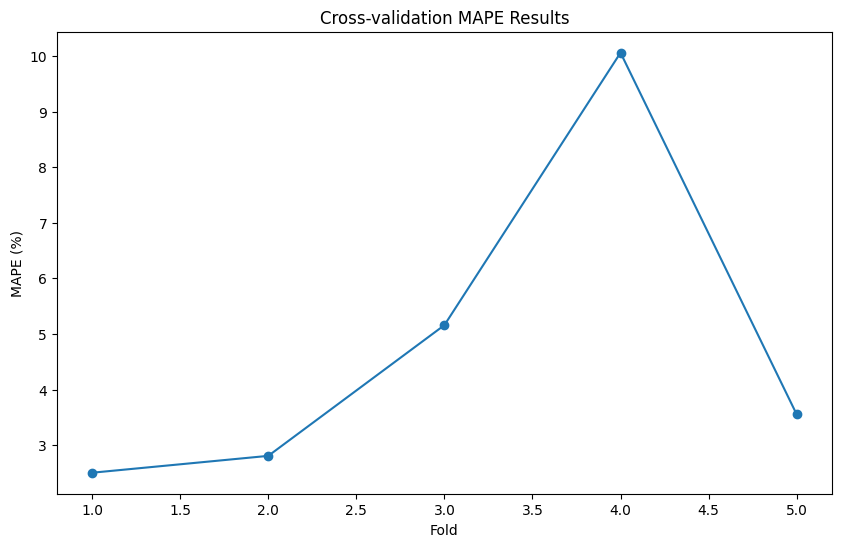

In [8]:
# ... (previous code remains the same)
#ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

# Define a function to perform time series cross-validation
def time_series_cv(data, n_splits, horizon):
    for i in range(n_splits):
        train_size = len(data) - (n_splits - i) * horizon
        train, test = data[:train_size], data[train_size:train_size+horizon]
        yield train, test

# Set parameters
n_splits = 5  # Number of splits for cross-validation
horizon = 12  # Forecast horizon (12 months)

# Perform cross-validation
cv_scores = []

for train, test in time_series_cv(ts, n_splits, horizon):
    # Fit the model
    model = SARIMAX(train, order=(0, 1, 2), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)
    
    # Make predictions
    predictions = results.forecast(steps=len(test))
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, predictions))
    cv_scores.append(rmse)

# Print cross-validation results
print("Cross-validation RMSE scores:", cv_scores)
print("Mean RMSE:", np.mean(cv_scores))
print("Standard deviation of RMSE:", np.std(cv_scores))

# Plot cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-validation Results')
plt.show()

# Calculate percentage error
mape_scores = []
for train, test in time_series_cv(ts, n_splits, horizon):
    model = SARIMAX(train, order=(0, 1, 2), seasonal_order=(1, 1, 1, 12), freq='ME')
    results = model.fit(disp=False)
    predictions = results.forecast(steps=len(test))
    mape = np.mean(np.abs((test - predictions) / test)) * 100
    mape_scores.append(mape)

print("Cross-validation MAPE scores:", mape_scores)
print("Mean MAPE:", np.mean(mape_scores))
print("Standard deviation of MAPE:", np.std(mape_scores))

# Plot MAPE results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mape_scores) + 1), mape_scores, marker='o')
plt.xlabel('Fold')
plt.ylabel('MAPE (%)')
plt.title('Cross-validation MAPE Results')
plt.show()

In [9]:
AirPassengersDF

,unique_id,y
ds,,
1949-01-31,1.0,112.0
1949-02-28,1.0,118.0
1949-03-31,1.0,132.0
1949-04-30,1.0,129.0
1949-05-31,1.0,121.0
...,...,...
1960-08-31,1.0,606.0
1960-09-30,1.0,508.0
1960-10-31,1.0,461.0


In [18]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
season_length = 12 # Monthly data 


models = [AutoARIMA(season_length=season_length)]
sf = StatsForecast(df=AirPassengersDF.reset_index(),
                   models=models,
                   freq='ME', 
                   n_jobs=-1)
fcst = sf.forecast(df=AirPassengersDF.reset_index(), h= 24, level = [95]).reset_index()
# arima_string(sf.fitted_[0,0].model_, padding=True)

In [16]:
df

,unique_id,y
ds,,
1949-01-31,1.0,112.0
1949-02-28,1.0,118.0
1949-03-31,1.0,132.0
1949-04-30,1.0,129.0
1949-05-31,1.0,121.0
...,...,...
1960-08-31,1.0,606.0
1960-09-30,1.0,508.0
1960-10-31,1.0,461.0


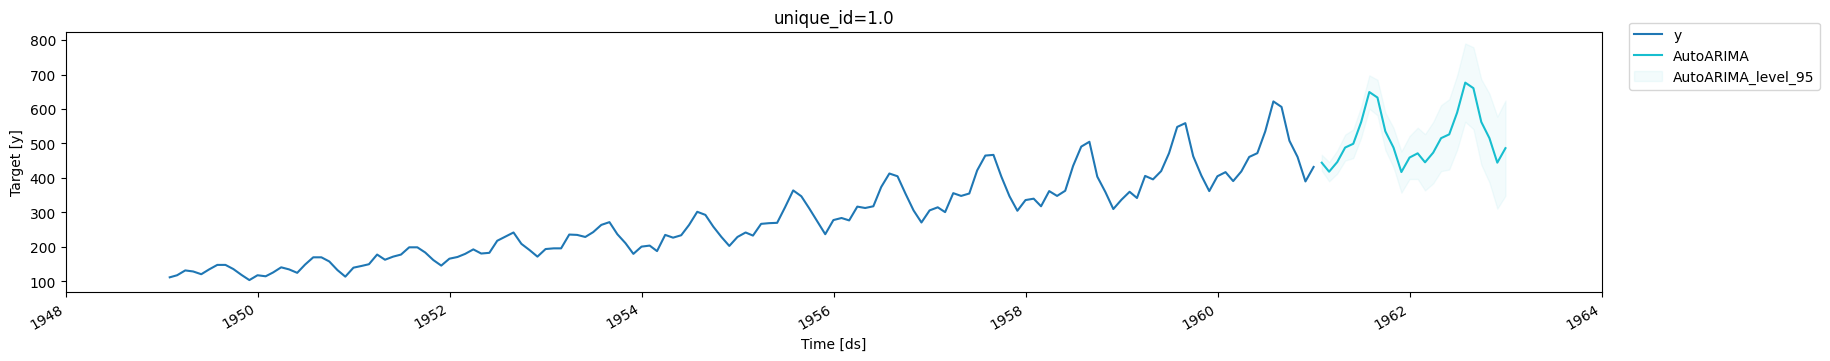

In [19]:
from utilsforecast.plotting import plot_series
plot_series(AirPassengersDF.reset_index(), fcst, level=[95])


In [39]:
print(df)

            unique_id      y
ds                          
1949-01-31        1.0  112.0
1949-02-28        1.0  118.0
1949-03-31        1.0  132.0
1949-04-30        1.0  129.0
1949-05-31        1.0  121.0
...               ...    ...
1960-08-31        1.0  606.0
1960-09-30        1.0  508.0
1960-10-31        1.0  461.0
1960-11-30        1.0  390.0
1960-12-31        1.0  432.0

[144 rows x 2 columns]


In [40]:
import numpy as np

def select_random_dates(df, num_dates):
    """
    Selects num_dates random dates from the 'ds' index of the DataFrame df.
    Returns a list of dates.
    """
    # Ensure the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DatetimeIndex.")

    # Get the unique dates in the DataFrame index
    dates = df.index.unique()

    # Check that num_dates is not greater than the number of available dates
    if num_dates > len(dates):
        raise ValueError("num_dates is greater than the number of available dates.")

    # Select random dates
    random_dates = np.random.choice(dates, size=num_dates, replace=False)
    # Sort the dates
    random_dates = np.sort(random_dates)
    return random_dates.tolist()


In [41]:
random_promo_dates = select_random_dates(df, num_dates=5)

# Convert dates to strings if needed
random_promo_dates_str = [date.strftime('%Y-%m-%d') for date in random_promo_dates]

print("Random Promotional Dates:")
for date in random_promo_dates_str:
    print(date)

AttributeError: 'int' object has no attribute 'strftime'

In [42]:
df

,unique_id,y
ds,,
1949-01-31,1.0,112.0
1949-02-28,1.0,118.0
1949-03-31,1.0,132.0
1949-04-30,1.0,129.0
1949-05-31,1.0,121.0
...,...,...
1960-08-31,1.0,606.0
1960-09-30,1.0,508.0
1960-10-31,1.0,461.0


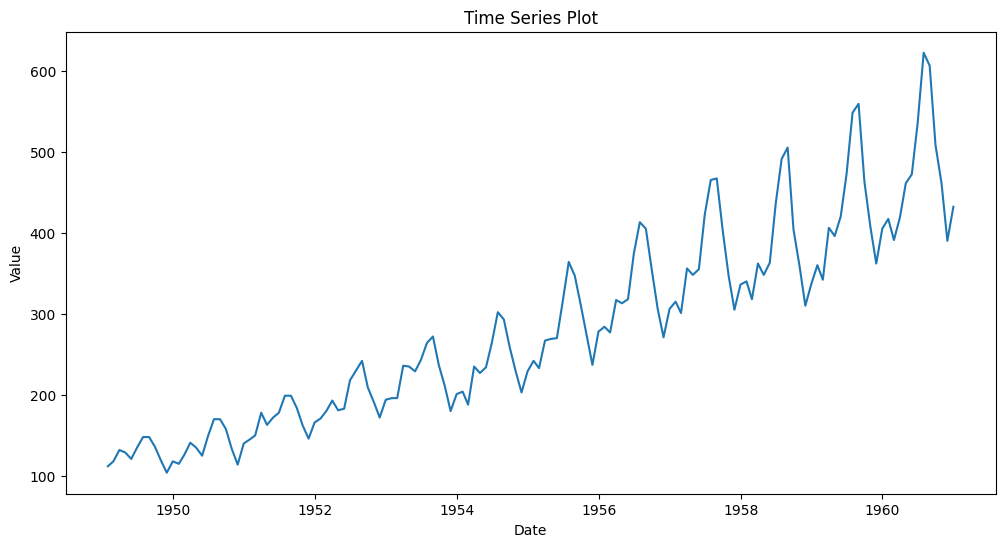

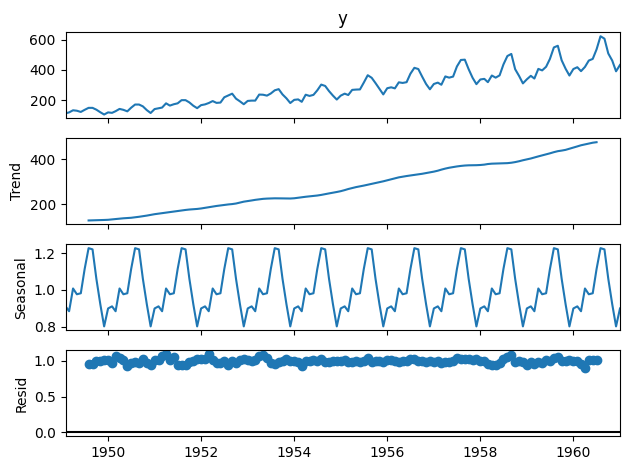

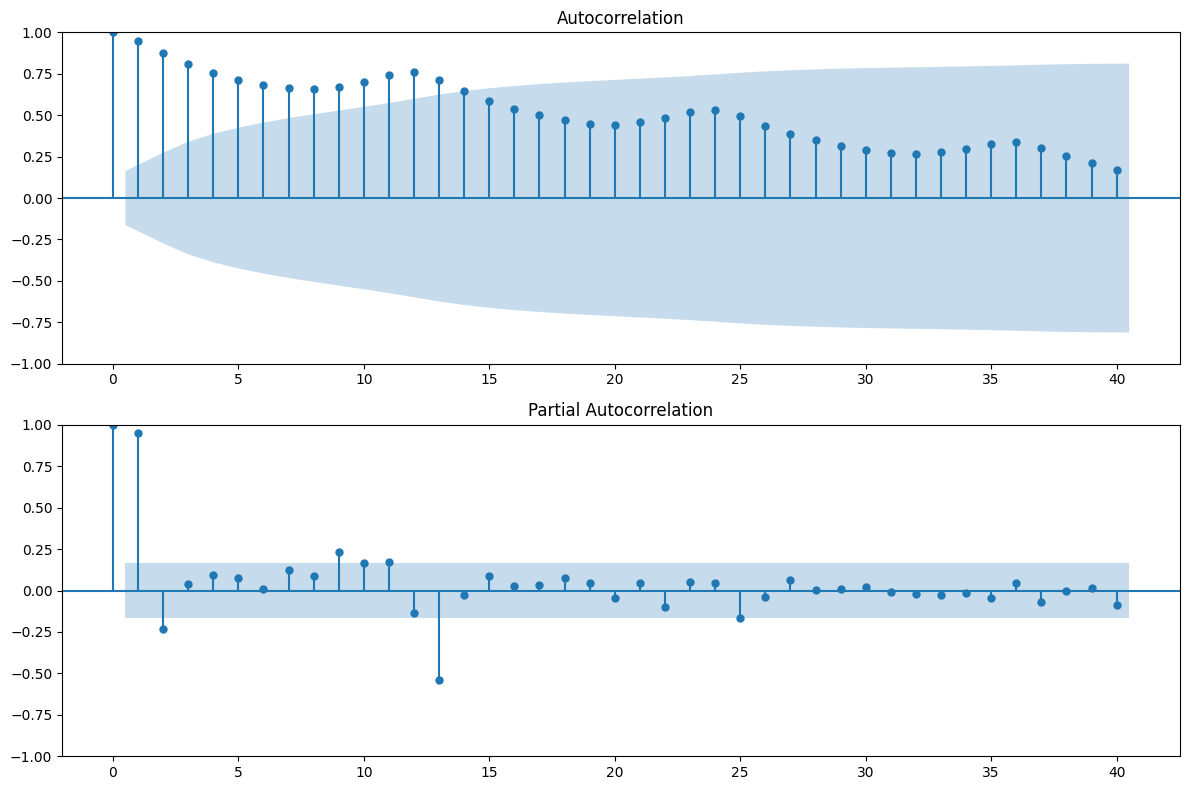

Testing stationarity of original series:
ADF Statistic: 0.8153688792060463
p-value: 0.991880243437641
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}
Weak evidence against null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Testing stationarity of differenced series:
ADF Statistic: -2.8292668241699923
p-value: 0.054213290283826474
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}
Weak evidence against null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:        

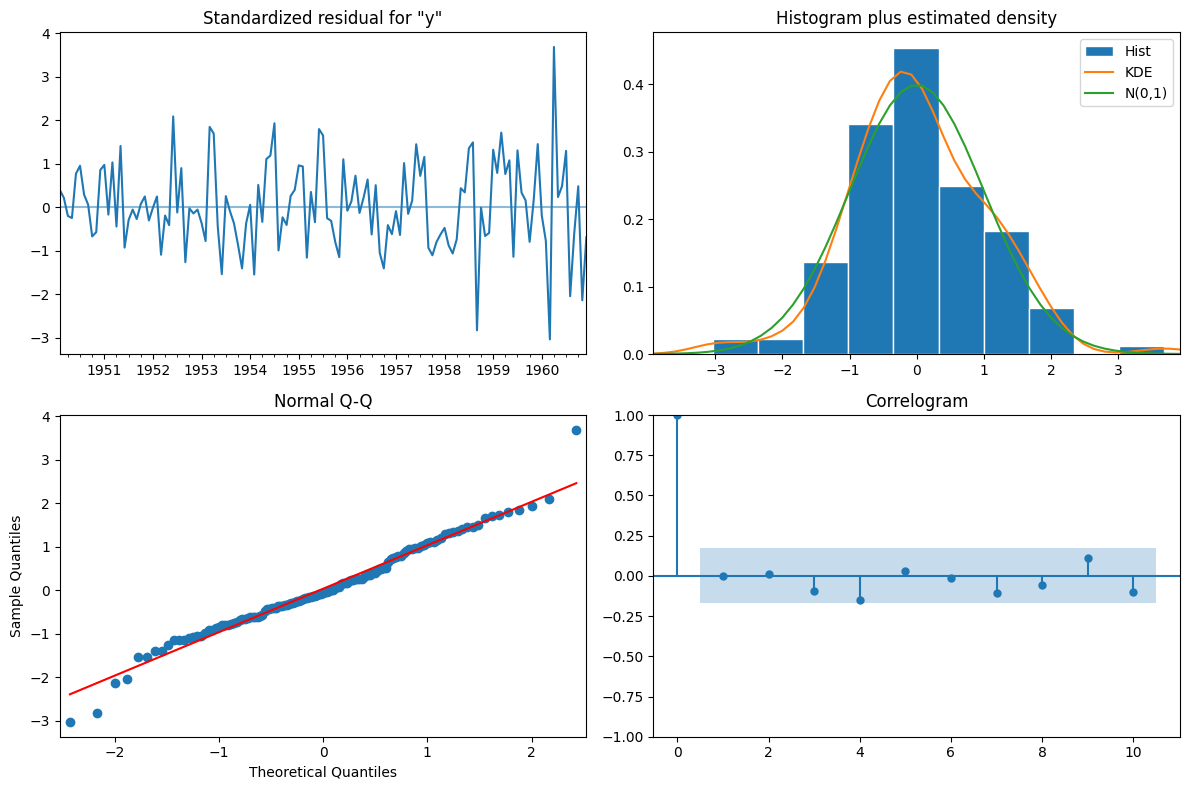

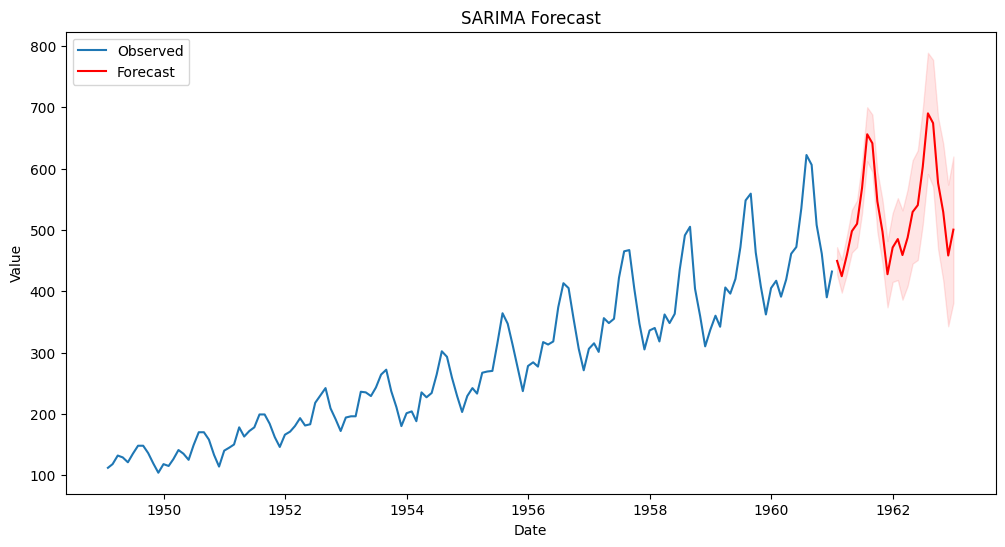

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -505.725
Date:                            Sun, 22 Sep 2024   AIC                           1023.450
Time:                                    22:58:00   BIC                           1040.701
Sample:                                01-31-1949   HQIC                          1030.460
                                     - 12-31-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
promo         -6.2442      6.105     -1.023      0.306     -18.209       5.721
ar.L1         -0.2466      0.361   

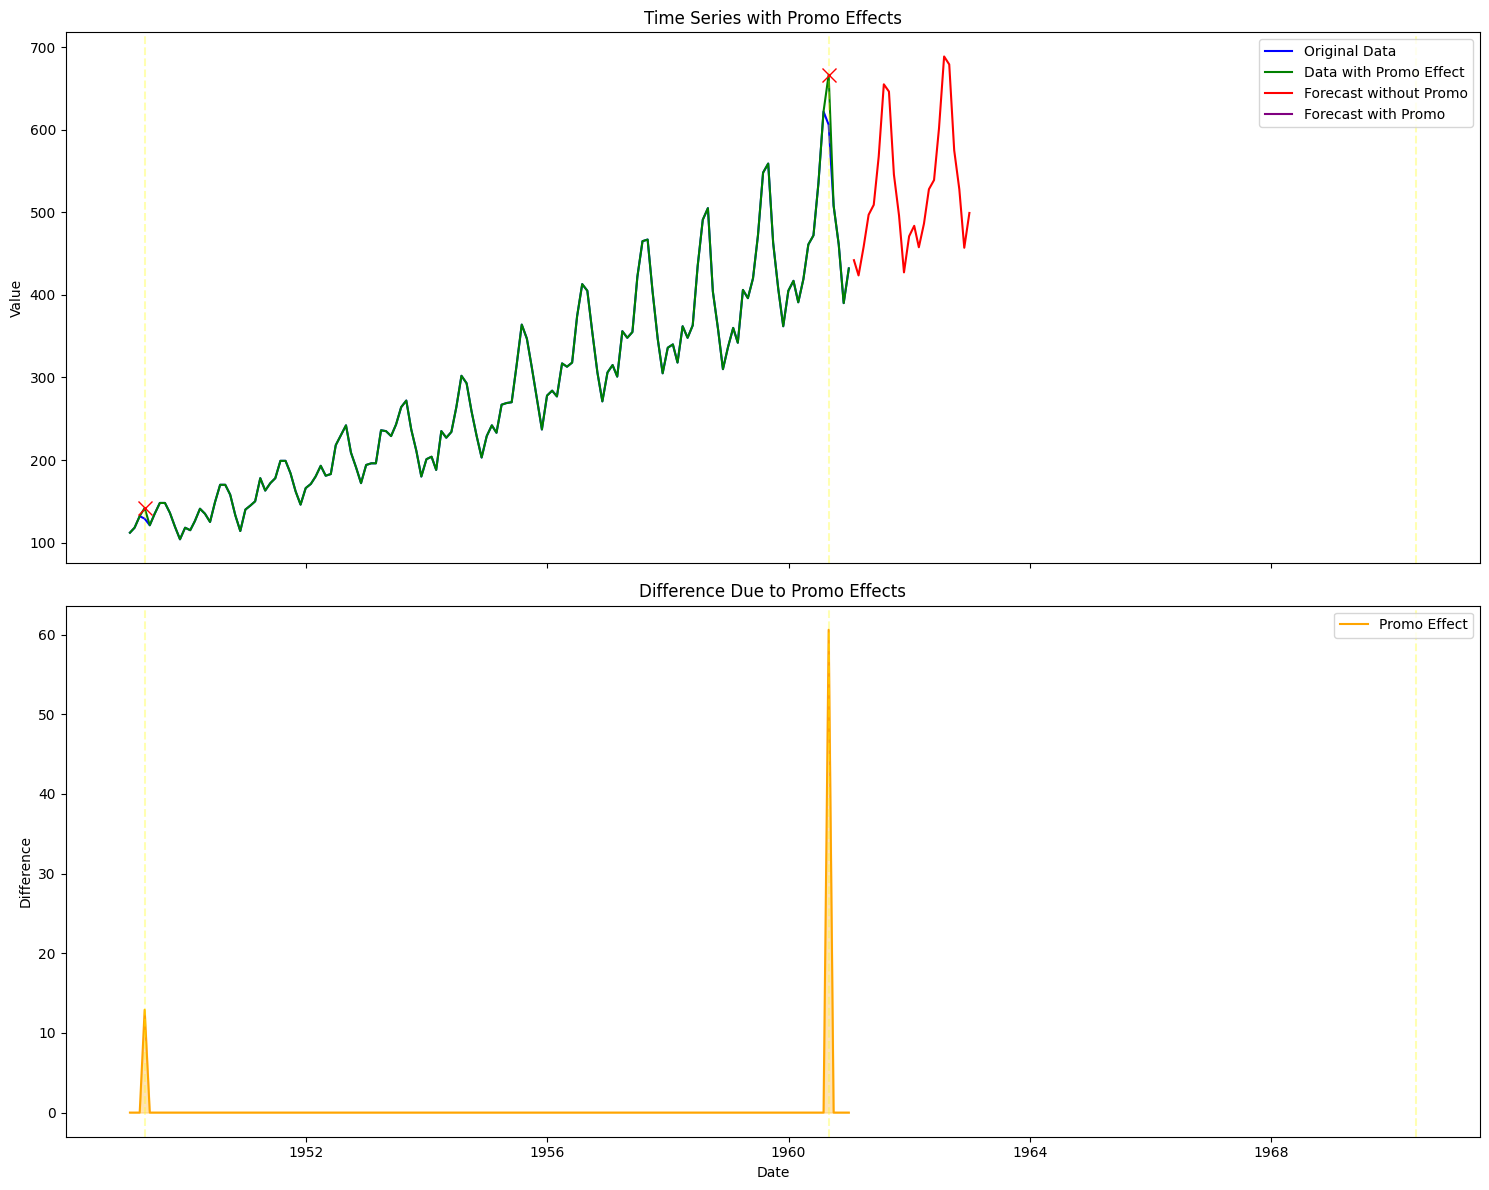

Promotional Periods and Their Effects:
Date: 1949-04-30
  Without Promo: 129.00
  With Promo: 141.90
  Difference: 12.90
  Percentage Increase: 10.00%

Date: 1960-08-31
  Without Promo: 606.00
  With Promo: 666.60
  Difference: 60.60
  Percentage Increase: 10.00%

Historical MAPE (with vs without Promo): 0.14%


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings

warnings.filterwarnings("ignore")
df = AirPassengersDF.reset_index()
# Load and prepare the data
# df = pd.read_csv('your_data.csv')  # Replace with your actual file name
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)
ts = df['y']

# 1. Exploratory Data Analysis
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Seasonal Decomposition
decomposition = seasonal_decompose(ts, model='multiplicative', period=12)
decomposition.plot()
plt.tight_layout()
plt.show()

# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts, ax=ax1, lags=40)
plot_pacf(ts, ax=ax2, lags=40)
plt.tight_layout()
plt.show()

# 2. Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

print("Testing stationarity of original series:")
test_stationarity(ts)

# Differencing if necessary
ts_diff = ts.diff().dropna()
print("\nTesting stationarity of differenced series:")
test_stationarity(ts_diff)

# 3. SARIMA Modeling
# You may need to adjust these parameters based on your ACF/PACF plots
p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, 12  # Assuming monthly data with yearly seasonality

model = SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, m))
results = model.fit()
print(results.summary())

# 4. Diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

# 5. Forecasting
forecast_steps = 24  # Forecasting 2 years ahead
forecast = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts, label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='r', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='r', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()
# 6. SARIMAX with Exogenous Variables (Promotions)
# Create promotional data
# Create promotional data with the same frequency as ts (monthly)
# Create promotional data with the same frequency as ts (monthly)
forecast_steps = 24  # Ensure this is defined before use
date_range = pd.date_range(start=ts.index.min(), end=ts.index.max() + pd.DateOffset(months=forecast_steps), freq='M')
promo_data = pd.DataFrame({'date': date_range})
promo_data['promo'] = 0

# Convert promo dates to datetime and get the corresponding months
past_promos = pd.to_datetime(['1960-08-31', '1949-04-30', '2021-01-10', '2021-06-20', '2022-02-14'])
future_promos = pd.to_datetime(['1961-01-31'])

# Get the unique months for all promos
promo_months = past_promos.to_period('M').unique()
future_promo_months = future_promos.to_period('M').unique()

# Corrected line using union
all_promo_months = promo_months.union(future_promo_months)

# Set 'promo' variable to 1 for months with promos
promo_data['promo'] = promo_data['date'].dt.to_period('M').isin(all_promo_months).astype(int)

# Merge with original data
df_with_promos = ts.to_frame().reset_index().merge(promo_data, left_on='ds', right_on='date', how='left')
df_with_promos.set_index('ds', inplace=True)

# Apply the promo effect to historical data
df_with_promos['y_with_promo'] = df_with_promos['y'] * (1 + 0.10 * df_with_promos['promo'])


# Proceed with modeling and forecasting as before...


# Fit SARIMAX model with original data and promo as exogenous variable
model_sarimax = SARIMAX(df_with_promos['y'], exog=df_with_promos['promo'],
                        order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  # Adjust orders as needed
results_sarimax = model_sarimax.fit()
print(results_sarimax.summary())

# Forecast
forecast_steps = 24  # Forecasting 2 years ahead
future_exog = promo_data.loc[promo_data['date'] > ts.index.max(), 'promo'][:forecast_steps]
forecast_sarimax = results_sarimax.get_forecast(steps=forecast_steps, exog=future_exog)

# Create forecast with promo effects
forecast_with_promo = forecast_sarimax.predicted_mean * (1 + 0.10 * future_exog)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot historical data and forecasts
ax1.plot(df_with_promos.index, df_with_promos['y'], label='Original Data', color='blue')
ax1.plot(df_with_promos.index, df_with_promos['y_with_promo'], label='Data with Promo Effect', color='green')
ax1.plot(forecast_sarimax.predicted_mean.index, forecast_sarimax.predicted_mean, label='Forecast without Promo', color='red')
ax1.plot(forecast_with_promo.index, forecast_with_promo, label='Forecast with Promo', color='purple')

# Highlight promo periods and add X marks
all_promos = df_with_promos[df_with_promos['promo'] == 1].index.tolist() + future_exog[future_exog == 1].index.tolist()
for date in all_promos:
    ax1.axvline(x=date, color='yellow', alpha=0.3, linestyle='--')
    if date in df_with_promos.index:
        ax1.plot(date, df_with_promos.loc[date, 'y_with_promo'], 'rx', markersize=10)
    elif date in forecast_with_promo.index:
        ax1.plot(date, forecast_with_promo.loc[date], 'rx', markersize=10)

ax1.set_ylabel('Value')
ax1.set_title('Time Series with Promo Effects')
ax1.legend()

# Plot difference between with and without promo
historical_diff = df_with_promos['y_with_promo'] - df_with_promos['y']
forecast_diff = forecast_with_promo - forecast_sarimax.predicted_mean
combined_diff = pd.concat([historical_diff, forecast_diff])

ax2.plot(combined_diff.index, combined_diff, label='Promo Effect', color='orange')
ax2.fill_between(combined_diff.index, 0, combined_diff, alpha=0.3, color='orange')

# Highlight promo periods in difference plot
for date in all_promos:
    ax2.axvline(x=date, color='yellow', alpha=0.3, linestyle='--')

ax2.set_xlabel('Date')
ax2.set_ylabel('Difference')
ax2.set_title('Difference Due to Promo Effects')
ax2.legend()

plt.tight_layout()
plt.show()

# Print out the dates and values for promo periods
print("Promotional Periods and Their Effects:")
all_data = pd.concat([df_with_promos, pd.DataFrame({'y': forecast_sarimax.predicted_mean, 'y_with_promo': forecast_with_promo}, index=forecast_with_promo.index)])
promo_comparison = all_data[all_data['promo'] == 1]
for date, row in promo_comparison.iterrows():
    print(f"Date: {date.date()}")
    print(f"  Without Promo: {row['y']:.2f}")
    print(f"  With Promo: {row['y_with_promo']:.2f}")
    print(f"  Difference: {row['y_with_promo'] - row['y']:.2f}")
    print(f"  Percentage Increase: {((row['y_with_promo'] / row['y']) - 1) * 100:.2f}%")
    print()

# Calculate overall MAPE
historical_mape = mean_absolute_percentage_error(df_with_promos['y'], df_with_promos['y_with_promo']) * 100
# forecast_mape = mean_absolute_percentage_error(forecast_sarimax.predicted_mean, forecast_with_promo) * 100

print(f"Historical MAPE (with vs without Promo): {historical_mape:.2f}%")
# print(f"Forecast MAPE (with vs without Promo): {forecast_mape:.2f}%")

In [46]:
forecast_with_promo

1961-01-31 00:00:00   NaN
1961-02-28 00:00:00   NaN
1961-03-31 00:00:00   NaN
1961-04-30 00:00:00   NaN
1961-05-31 00:00:00   NaN
1961-06-30 00:00:00   NaN
1961-07-31 00:00:00   NaN
1961-08-31 00:00:00   NaN
1961-09-30 00:00:00   NaN
1961-10-31 00:00:00   NaN
1961-11-30 00:00:00   NaN
1961-12-31 00:00:00   NaN
1962-01-31 00:00:00   NaN
1962-02-28 00:00:00   NaN
1962-03-31 00:00:00   NaN
1962-04-30 00:00:00   NaN
1962-05-31 00:00:00   NaN
1962-06-30 00:00:00   NaN
1962-07-31 00:00:00   NaN
1962-08-31 00:00:00   NaN
1962-09-30 00:00:00   NaN
1962-10-31 00:00:00   NaN
1962-11-30 00:00:00   NaN
1962-12-31 00:00:00   NaN
144                   NaN
145                   NaN
146                   NaN
147                   NaN
148                   NaN
149                   NaN
150                   NaN
151                   NaN
152                   NaN
153                   NaN
154                   NaN
155                   NaN
156                   NaN
157                   NaN
158         